# Imports

In [2]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDConfig
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import PropertyMol
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing,DrawingOptions
DrawingOptions.bondLineWidth=1.8
DrawingOptions.includeAtomNumbers=False   #change if you want atom numbering
size = (150, 150)                         # Smaller figures than the default
from rdkit.Chem.Draw.MolDrawing import Font
from rdkit.Chem import rdmolfiles # to be able to save PDB files
from rdkit.Chem import rdFMCS #maximum common subgraph (MCS)
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit import DataStructs

import pandas as pd
import re
from bs4 import BeautifulSoup
from smilite.smilite import get_zincid_from_smile
import concurrent.futures
import requests
from tqdm import tqdm
from time import sleep

# Load Structures

In [3]:
#change to import multiple csv files and combine them
csv_name = 'combined_filtered.csv'
smiles_column_name = 'smiles'

input_df = pd.read_csv(csv_name)

smiles_list = input_df[smiles_column_name].tolist()
mol_list = [Chem.MolFromSmiles(s) for s in smiles_list]
print(f'Loaded {len(mol_list)} structures from {csv_name}')
input_df

Loaded 2774 structures from combined_filtered.csv


,Unnamed: 0.1,smiles,zinc_id,Combi-Blocks,Matrix Scientific,AK Scientific,Enamine,AstaTech,Sigma Aldrich,Alfa Aesar,AmBeed,aaBlocks,AChemBlock,ChemImpex,BioSynth,Unnamed: 0
0,0,Cc1cc(=O)[nH]c(Nc2nc3ccccc3[nH]2)n1,8652428,NaN,NaN,NaN,NaN,"=HYPERLINK(""http://astatechinc.com/CPSResult.p...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Cc1cc(=O)[nH]c(Nc2ccccc2)n1,17782157,"=HYPERLINK(""http://www.combi-blocks.com/cgi-bi...",NaN,NaN,NaN,NaN,"=HYPERLINK(""https://www.sigmaaldrich.com/US/en...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Cc1cc(=O)[nH]c(Nc2nc3ccccc3o2)n1,17747472,"=HYPERLINK(""http://www.combi-blocks.com/cgi-bi...",NaN,NaN,NaN,"=HYPERLINK(""http://astatechinc.com/CPSResult.p...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,c1cncc(Nc2nnc[nH]2)c1,225807495,NaN,NaN,NaN,"=HYPERLINK(""https://www.enaminestore.com/catal...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,C#CCOc1cccc(Nc2cccnc2)c1,952959914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"=HYPERLINK(""http://www.achemblock.com/catalogs...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2769,2769,CCCCN(CCCC)c1nc(S)[nH]c(=S)n1,2564432,"=HYPERLINK(""http://www.combi-blocks.com/cgi-bi...",NaN,"=HYPERLINK(""https://aksci.com/item_detail.php?...",NaN,"=HYPERLINK(""http://astatechinc.com/CPSResult.p...",NaN,NaN,NaN,"=HYPERLINK(""https://www.aablocks.com/prod/AA00...",NaN,NaN,NaN,NaN
2770,2770,CCSCCN(CCSCC)c1ccccc1,2166475,NaN,NaN,NaN,NaN,NaN,"=HYPERLINK(""https://www.sigmaaldrich.com/US/en...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2771,2771,COCCN(CCOC)c1ccc(B2OC(C)(C)C(C)(C)O2)cn1,214107940,NaN,NaN,"=HYPERLINK(""https://aksci.com/item_detail.php?...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2772,2772,CCCCOC(=O)CN(C(=S)NC(=O)c1ccccc1)c1ccccc1,5567797,NaN,NaN,NaN,NaN,NaN,"=HYPERLINK(""https://www.sigmaaldrich.com/US/en...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#make list much smaller for testing later
#input_df = input_df.iloc[0:5000:50, :]

# Fragmentation

The fragmentation patterns are defined in the dictionary below, there are two reaction patterns for each class of molecules, one to generate the bromide and one to generate the amine. The SM section of each reaction pattern is also used to filter the molecules to ensure each one is compatible with the fragmentation pattern that is used for it. Each class of molecule is stored in a dictionary with the same key as the reaction pattern dictionary.

The molecule classes are described below:

Type1 = secondary biarylamines (reaction of a primary (het)aniline and an aryl halide)

*symmetrical amines will produce exactly 2 fragments, aysymmetrical amines will produce exactly 4 fragments*

e.g.
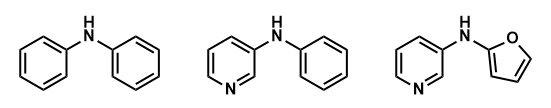

Type2 = secondary alkyl anilines (reaction of a primary alkyl amine and an aryl halide)

e.g.

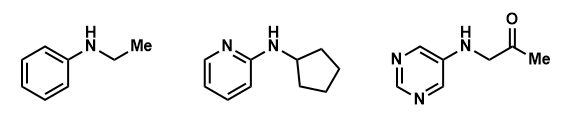

Type3 = tertiary (bi+)arylamines with acyclic backbone (reaction of secondary (bi)arylamine with aryl halide)

*this will produce multiple fragments depending on how the amine functional groups are designated*

e.g.
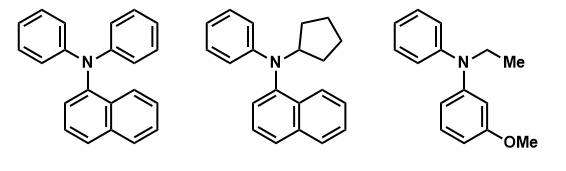

Type4 = tertiary alkyl anilines with cyclic backbones (reaction of a cylic secondary alykl amine and an aryl halide)

e.g.

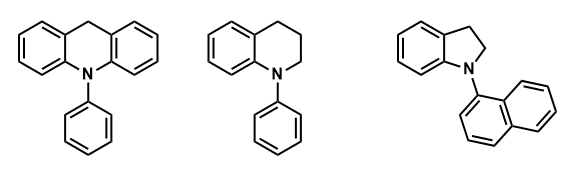

Type5 = tertiary anilines (reaction of secondary alkylamine with aryl halide)

*this will produce exactly 2 fragments*

e.g.
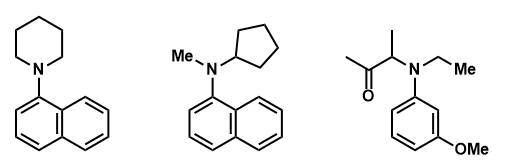

## Determine fragmentation type required by each substrate

In [4]:
#define the fragmentation patterns, smarts of starting materials also used to sort molecules
Br = Chem.MolFromSmiles('Br')
rxn_strings_dict = {
    'type1' : '[N$(N(c)c)H1:1]([c:2])[c:3].[Br:4]>>[N$(N(c)c)H2:1][c:2].[c:3][Br:4]', #tested
    'type2' : '[N$(N(C)c)H:1]([c:2])[C:3].[Br:4]>>[NH2:1][C:3].[c:2][Br:4]', #tested
    'type3' : '[NH0:1]([c:2])([c:3])[c:4].[Br:5]>>[NH0:1]([c:2])[c:3].[c:4][Br:5]', #tested
    'type4' : '[NRH0:1](@[cR2:2])(@[*R:3])[cR:4].[Br]>>[NRH1:1]([cR2:2])[*R:3].[cR:4][Br]', #tested
    'type5' : '[NH0:1]([C:2])([C:3])[c:4].[Br]>>[NH1:1]([C:2])[C:3].[c:4][Br]' #tested
}

#compile all of the reaction strings into objects and put in new dictionary
rxn_dict = {}
for key in rxn_strings_dict.keys():
    try:
        rxn_dict[key] = AllChem.ReactionFromSmarts(rxn_strings_dict[key])
    except:
        print(f'SMARTS not read correctly for {key}')
        continue

## visualized reaction patterns
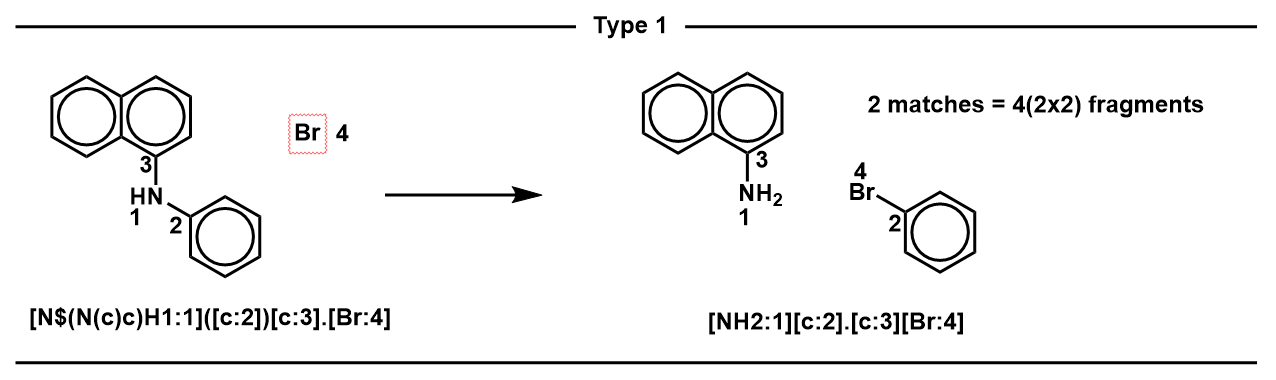
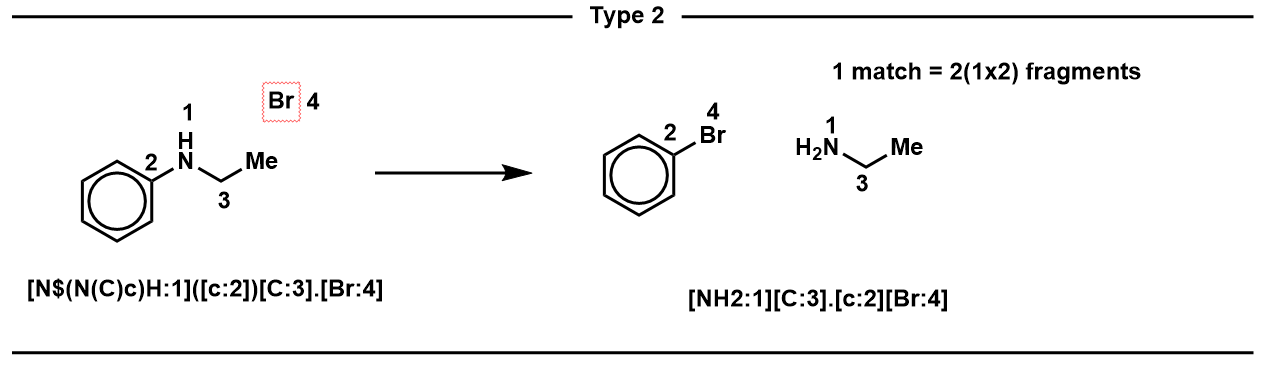
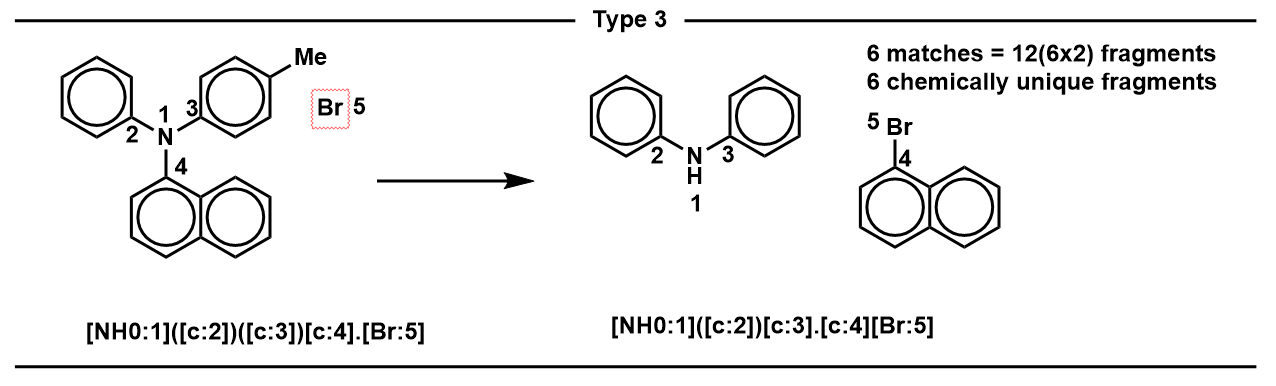
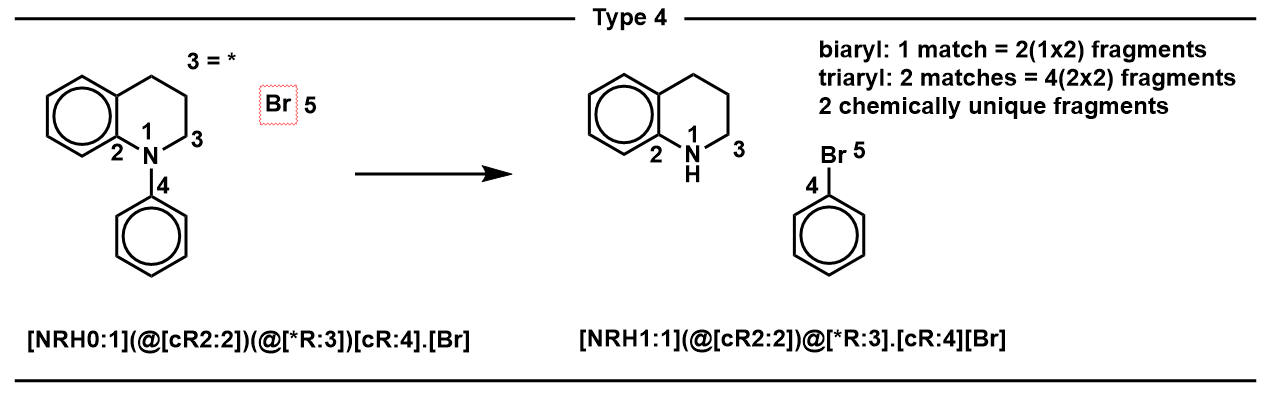
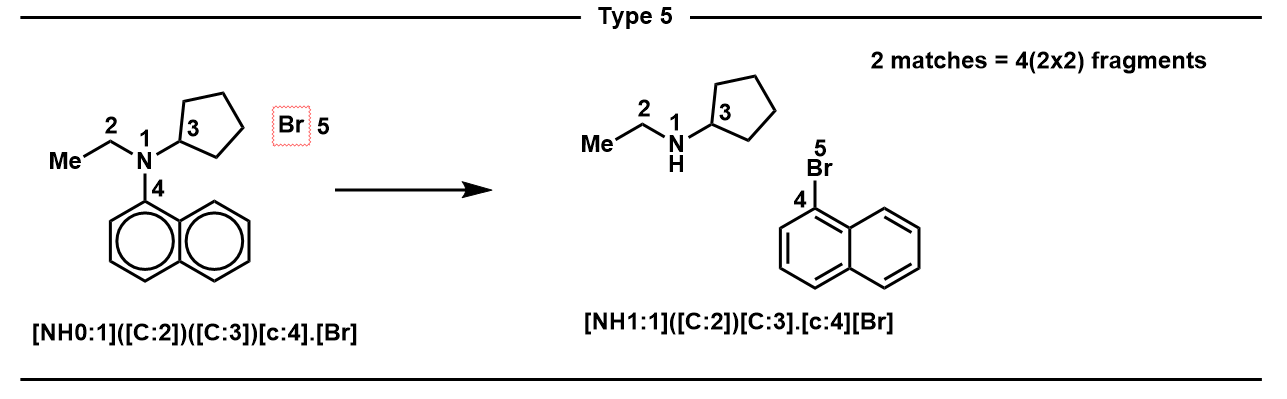

In [5]:
#initialize the data structures:
mol_dict = {}
results_dict = {}
for key in rxn_dict.keys(): #use this instead of rxn_strings_dict in case some smarts strings arent read correctly
    mol_dict[key] = []
    results_dict[key] = {}
    
#extract sm smarts information and sort molecules:
for mol in mol_list:
    for typ in rxn_strings_dict.keys():
        sm_smarts = rxn_strings_dict[typ].split('.')[0]
        if sm_smarts == '':
            continue
        else:
            sm_smarts = Chem.MolFromSmarts(sm_smarts)
        #if matches substructure and isnt already in the dictionary somewhere:
        if mol.HasSubstructMatch(sm_smarts) and not any([mol in sublist for sublist in list(mol_dict.values())]):
            mol_dict[typ].append(mol)

## Fragment molecules according to appropriate fragmentation pattern

In [6]:
#fragment molecules accordingly
for typ in mol_dict.keys():
    if mol_dict[typ] == []:
        print(f'No matches of {typ} from the input structures.')
        continue
    reaction = rxn_dict[typ]
    results_dict[typ] = {}
    for sm in mol_dict[typ]:
        fragments_mol_tups = list(reaction.RunReactants((sm,Br)))
        fragments_smiles_tups = []
        for i,j in fragments_mol_tups:
            i = Chem.MolToSmiles(i, isomericSmiles = True)
            j = Chem.MolToSmiles(j, isomericSmiles = True)
            if 'Br' in i: #finds electrophile and nucleophile to put in consistent order
                e = i
                n = j
            else:
                e = j
                n = i
            if (e,n) not in fragments_smiles_tups: #prevents duplicate fragmentations
                fragments_smiles_tups.append((e,n))
        results_dict[typ][Chem.MolToSmiles(sm, isomericSmiles = True)] = fragments_smiles_tups
results_dict

No matches of type3 from the input structures.


{'type1': {'Cc1cc(=O)[nH]c(Nc2nc3ccccc3[nH]2)n1': [('Brc1nc2ccccc2[nH]1',
    'Cc1cc(=O)[nH]c(N)n1'),
   ('Cc1cc(=O)[nH]c(Br)n1', 'Nc1nc2ccccc2[nH]1')],
  'Cc1cc(=O)[nH]c(Nc2ccccc2)n1': [('Brc1ccccc1', 'Cc1cc(=O)[nH]c(N)n1'),
   ('Cc1cc(=O)[nH]c(Br)n1', 'Nc1ccccc1')],
  'Cc1cc(=O)[nH]c(Nc2nc3ccccc3o2)n1': [('Brc1nc2ccccc2o1',
    'Cc1cc(=O)[nH]c(N)n1'),
   ('Cc1cc(=O)[nH]c(Br)n1', 'Nc1nc2ccccc2o1')],
  'c1cncc(Nc2nnc[nH]2)c1': [('Brc1nnc[nH]1', 'Nc1cccnc1'),
   ('Brc1cccnc1', 'Nc1nnc[nH]1')],
  'C#CCOc1cccc(Nc2cccnc2)c1': [('Brc1cccnc1', 'C#CCOc1cccc(N)c1'),
   ('C#CCOc1cccc(Br)c1', 'Nc1cccnc1')],
  'N#Cc1ccc(Nc2nccc(Cl)n2)cc1': [('Clc1ccnc(Br)n1', 'N#Cc1ccc(N)cc1'),
   ('N#Cc1ccc(Br)cc1', 'Nc1nccc(Cl)n1')],
  'N#Cc1ccnc(Nc2ccc(F)cc2)c1': [('Fc1ccc(Br)cc1', 'N#Cc1ccnc(N)c1'),
   ('N#Cc1ccnc(Br)c1', 'Nc1ccc(F)cc1')],
  'N#Cc1cccnc1Nc1ccc(F)cc1': [('Fc1ccc(Br)cc1', 'N#Cc1cccnc1N'),
   ('N#Cc1cccnc1Br', 'Nc1ccc(F)cc1')],
  'N#Cc1ccc(Nc2ccc(Cl)nn2)cc1': [('Clc1ccc(Br)nn1', 'N#Cc1ccc(N)cc1'

# Export Fragments As-Is (optional)

In [7]:
skip_this_cell = True

if skip_this_cell == False:
    for typ in results_dict.keys():
        if results_dict[typ] == {}:
            continue
        output1_df = pd.DataFrame()
        output1_df['parent'] = results_dict[typ].keys()
        SplitA_FragE, SplitA_FragN, SplitB_FragE, SplitB_FragN, SplitC_FragE, SplitC_FragN = [],[],[],[],[],[]

        for parent in results_dict[typ].keys():
            try:
                SplitA_FragE.append(results_dict[typ][parent][0][0])
                SplitA_FragN.append(results_dict[typ][parent][0][1])
            except:
                SplitA_FragE.append('')
                SplitA_FragN.append('')
            try:
                SplitB_FragE.append(results_dict[typ][parent][1][0])
                SplitB_FragN.append(results_dict[typ][parent][1][1])
            except:
                SplitB_FragE.append('')
                SplitB_FragN.append('')
            try:
                SplitC_FragE.append(results_dict[typ][parent][2][0])
                SplitC_FragN.append(results_dict[typ][parent][2][1])
            except:
                SplitC_FragE.append('')
                SplitC_FragN.append('')

        output1_df['SplitA_FragE'] = SplitA_FragE
        output1_df['SplitA_FragN'] = SplitA_FragN
        output1_df['SplitB_FragE'] = SplitB_FragE
        output1_df['SplitB_FragN'] = SplitB_FragN
        output1_df['SplitC_FragE'] = SplitC_FragE
        output1_df['SplitC_FragN'] = SplitC_FragN

        output1_df.to_csv(f'{csv_name[:-4]}_{typ}_frags_unfiltered.csv', index = False)
        print(f'Exported molecules/fragments of {typ} to {csv_name[:-4]}_{typ}_frags_unfiltered.csv')

# Filter Molecules Based on Commercial Availability of Fragment Pairs

## Definitions

In [7]:
#To add new vendors: you must add information in the 3 places below: name, url_pattern, and cat_pattern
#nothing else needs changing

#list of vendors as they would appear on a ZINC substance page
vendors = {}
vendors['names'] = [
    'Combi-Blocks',
    'Matrix Scientific',
    'AK Scientific',
    'Enamine', #building blocks only, no make-on-demand
    'AstaTech',
    'Sigma Aldrich',
    'Alfa Aesar',
    'AmBeed',
    #'Acros',
    'aaBlocks',
    'AChemBlock',
    'ChemImpex',
    'BioSynth' #same as carbosynth
]

vendors['url_patterns'] = []
#regex expressions for URL capture, must be in same order as vendor list above
combi_blocks_url_pattern = re.compile('https?:\/\/(?:www\.)?combi-blocks\.com\/\S*'); vendors['url_patterns'].append(combi_blocks_url_pattern)
matrix_scientific_url_pattern = re.compile('https?:\/\/(?:www\.)?matrixscientific\.com\/\S*'); vendors['url_patterns'].append(matrix_scientific_url_pattern)
ak_scientific_url_pattern = re.compile('http[s]?:\/\/[www\.]?aksci\.com\/\S*'); vendors['url_patterns'].append(ak_scientific_url_pattern)
enamine_url_pattern = re.compile('https?:\/\/(?:www\.)?enaminestore\.com\/.*(?:\/EN)\S*'); vendors['url_patterns'].append(enamine_url_pattern)
astatech_url_pattern = re.compile('https?:\/\/(?:www\.)?astatechinc\.com\/\S*'); vendors['url_patterns'].append(astatech_url_pattern)
sigma_aldrich_url_pattern = re.compile('https?:\/\/(?:www\.)?sigmaaldrich\.com\/catalog\/search\?term=\w+[^|]+\w+'); vendors['url_patterns'].append(sigma_aldrich_url_pattern)
alfa_aesar_url_pattern = re.compile('https?:\/\/(?:www\.)?alfa\.com\S*'); vendors['url_patterns'].append(alfa_aesar_url_pattern)
ambeed_url_pattern = re.compile('https?:\/\/(?:www\.)?ambeed\.com\/\S*'); vendors['url_patterns'].append(ambeed_url_pattern)
#acros_url_pattern = re.compile(''); vendors['url_patterns'].append(acros_url_pattern)
aablocks_url_pattern = re.compile('https?:\/\/(?:www\.)?aablocks\.com\/\S*'); vendors['url_patterns'].append(aablocks_url_pattern)
achemblock_url_pattern = re.compile('https?:\/\/(?:www\.)?achemblock\.com\/\S*'); vendors['url_patterns'].append(achemblock_url_pattern)
chemimpex_url_pattern = re.compile('https?:\/\/(?:www\.)?chemimpex\.com\/\S*'); vendors['url_patterns'].append(chemimpex_url_pattern)
biosynth_url_pattern = re.compile('https?:\/\/(?:www\.)?biosynth\.com\/\S*'); vendors['url_patterns'].append(biosynth_url_pattern)

vendors['cat_patterns'] = []
#regex expressions for catalog #s pulled from the URL matches, must be in same order as everything above, all catalog numbers are returned in group1 of the re search
combi_blocks_cat_pattern = re.compile('(?:\/cgi-bin\/find\.cgi\?)(\w+[^\w]{1}\w+)'); vendors['cat_patterns'].append(combi_blocks_cat_pattern)
matrix_scientific_cat_pattern = re.compile('matrixscientific\.com\/(\w+)\.html'); vendors['cat_patterns'].append(matrix_scientific_cat_pattern)
ak_scientific_cat_pattern = re.compile('cat=(\w*)'); vendors['cat_patterns'].append(ak_scientific_cat_pattern)
enamine_cat_pattern = re.compile('catalog\/(EN\w+-\w+)'); vendors['cat_patterns'].append(enamine_cat_pattern)
astatech_cat_pattern = re.compile('CRNO=(\w*)'); vendors['cat_patterns'].append(astatech_cat_pattern) #this isnt actual catalog number, just URL number?
sigma_aldrich_cat_pattern = re.compile('(?:catalog\/search\?term=)(\w+)\W'); vendors['cat_patterns'].append(sigma_aldrich_cat_pattern)
alfa_aesar_cat_pattern = re.compile('catalog\/(\w*)'); vendors['cat_patterns'].append(alfa_aesar_cat_pattern)
ambeed_cat_pattern = re.compile('keyword=(\w*)'); vendors['cat_patterns'].append(ambeed_cat_pattern)
#acros_cat_pattern = re.compile(''); vendors['cat_patterns'].append(acros_cat_pattern)
aablocks_cat_pattern = re.compile('id=(\w*)'); vendors['cat_patterns'].append(aablocks_cat_pattern)
achemblock_cat_pattern = re.compile('q=(\w*)'); vendors['cat_patterns'].append(achemblock_cat_pattern)
chemimpex_cat_pattern = re.compile('search=(\w*)'); vendors['cat_patterns'].append(chemimpex_cat_pattern)
biosynth_cat_pattern = re.compile('(?<!\/en\/)products\/([\w,-]*)'); vendors['cat_patterns'].append(biosynth_cat_pattern)

def get_zincid(smiles):
    zincid = get_zincid_from_smile(smiles)
    if zincid == []:
        return('')
    else:
        zincid = zincid[0]
        return(zincid)
    
def download_url(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html')
    return soup

def get_commercial_data(zincid):
    url = f'https://zinc.docking.org/substances/{zincid}/'
    soup = download_url(url)
    
    url_list = []
    for tag in soup.find_all('a'):
        url_list.append(tag.get('href'))
    
    commercial_data_id = []
    for i in range(len(vendors['names'])):
        matches = [x for x in url_list if re.search(vendors['url_patterns'][i], x)]
        if len(matches) != 0:
            target_url = matches[0]
            target_cat = re.search(vendors['cat_patterns'][i],target_url).group(1)
            target_tup = target_url,target_cat
            commercial_data_id.append(target_tup)
        else:
            commercial_data_id.append(('',''))  
    return(commercial_data_id)


## Web Scraping

In [8]:
#look up zincid
#make a set dataframe of fragments, separate electrophiles and nucleophiles
#itterate through it scraping web for suppliers
#filter through the parent dataframe, removing any that have no fragment pairs in the filtered fragment dataframe'


#organize fragments
output_df_dict = {}
fragments_master_list = []
for typ in results_dict.keys():
    if results_dict[typ] == {}:
        continue
    output_df = pd.DataFrame()
    
    #convert to mol then back to canonical smiles for searching later, don't remember where these smiles were generated
    output_df_parent_mols = [Chem.MolFromSmiles(x) for x in results_dict[typ].keys()]
    output_df['parent'] = [Chem.MolToSmiles(y, isomericSmiles = True) for y in output_df_parent_mols]
    
    SplitA_FragE, SplitA_FragN, SplitB_FragE, SplitB_FragN, SplitC_FragE, SplitC_FragN = [],[],[],[],[],[]

    for parent in results_dict[typ].keys():
        try:
            SplitA_FragE.append(results_dict[typ][parent][0][0])
            SplitA_FragN.append(results_dict[typ][parent][0][1])
        except:
            SplitA_FragE.append('')
            SplitA_FragN.append('')
        try:
            SplitB_FragE.append(results_dict[typ][parent][1][0])
            SplitB_FragN.append(results_dict[typ][parent][1][1])
        except:
            SplitB_FragE.append('')
            SplitB_FragN.append('')
        try:
            SplitC_FragE.append(results_dict[typ][parent][2][0])
            SplitC_FragN.append(results_dict[typ][parent][2][1])
        except:
            SplitC_FragE.append('')
            SplitC_FragN.append('')
    
    #there's probably a way to do this in a generated fashion based on the max number of fragment pairs
    output_df['SplitA_FragE'] = SplitA_FragE
    output_df['SplitA_FragN'] = SplitA_FragN
    output_df['SplitB_FragE'] = SplitB_FragE
    output_df['SplitB_FragN'] = SplitB_FragN
    output_df['SplitC_FragE'] = SplitC_FragE
    output_df['SplitC_FragN'] = SplitC_FragN
    output_df_dict[typ] = output_df.copy()

    #generate master list of fragments, could keep nucleophiles and electrophiles separate if you want
    fragments_master_list_toadd = output_df['SplitA_FragE'].tolist() + output_df['SplitA_FragN'].tolist() + output_df['SplitB_FragE'].tolist() + output_df['SplitB_FragN'].tolist() + output_df['SplitC_FragE'].tolist() + output_df['SplitC_FragN'].tolist()
    fragments_master_list_toadd = [x for x in fragments_master_list_toadd if x != ''] #gets rid of empty values
    fragments_master_list += fragments_master_list_toadd

#for scraping zinc_id, there's other ways/places to get this info
fragments_master_df = pd.DataFrame()
fragments_master_df['smiles'] = fragments_master_list
print(f'''Looking up ZINC ID for {len(fragments_master_df['smiles'])} fragments...''')

interval_len = 50
smiles_list2 = fragments_master_df['smiles'].tolist()
zincid_list = []
for interval in tqdm(range(int(len(smiles_list2) / interval_len) + (len(smiles_list2) % interval_len > 0))):
    smiles_list_interval_start = interval * interval_len
    smiles_list_interval_end = interval_len * (interval + 1)
    try:
        smiles_list_interval = smiles_list2[smiles_list_interval_start:smiles_list_interval_end]
    except:
        smiles_list_interval = smiles_list2[smiles_list_interval_start:]
    while True: #watchdog loop for making sure disconnections don't cause exceptions, retries interval instead
        try:
            with concurrent.futures.ThreadPoolExecutor() as executor:
                zincid_results =  executor.map(get_zincid, smiles_list_interval)
                zincid_list_interval = [result for result in zincid_results]
                zincid_list += zincid_list_interval
            break
        except Exception:
            print('Disconnected: Retrying block of SMILES.')
            continue
    #sleep(1)
    
fragments_master_df['zinc_id'] = zincid_list

#for scraping commercial availability
print(f'''Looking up commercial vendors for {len(fragments_master_df['smiles'])} fragments...''')
interval_len = 100
commercial_data = []
for interval in tqdm(range(int(len(zincid_list) / interval_len) + (len(zincid_list) % interval_len > 0))):
    zincid_list_interval_start = interval * interval_len
    zincid_list_interval_end = interval_len * (interval + 1)
    try:
        zincid_list_interval = zincid_list[zincid_list_interval_start:zincid_list_interval_end]
    except:
        zincid_list_interval = zincid_list[zincid_list_interval_start:]
    while True: #watchdog loop for making sure disconnections don't cause exceptions, retries interval instead
        try:
            with concurrent.futures.ThreadPoolExecutor() as executor:
                commercial_data_results = executor.map(get_commercial_data,zincid_list_interval)
                commercial_data_interval = [result for result in commercial_data_results]
                commercial_data += commercial_data_interval
            break
        except Exception:
            print('Disconnected: Retrying block of URLs.')
            continue
    sleep(0.5) #idk feels like there should be time between intervals
    
commercial_data = list(map(list, zip(*commercial_data))) #transpose the list of lists

for k in range(len(vendors['names'])):
    link_list = []
    for link_location,link_name in  commercial_data[k]:
        if link_location == '' and link_name == '':
            link_list.append('')
        else:
            link_list.append(f'''=HYPERLINK("{link_location}","{link_name}")''')

    fragments_master_df[vendors['names'][k]] = link_list

Looking up ZINC ID for 6178 fragments...


100%|██████████| 124/124 [12:39<00:00,  6.12s/it]


Looking up commercial vendors for 6178 fragments...


100%|██████████| 62/62 [11:06<00:00, 10.74s/it]


## Export Master Fragment List with Vendors (optional)

In [11]:
 fragments_master_df.to_csv('fragments_master_list_vendors.csv', index = False)

## Filter List, Remove Fragments with no Vendors

In [9]:
#remove compounds not available from any of the specified vendors
filtered_fragments_master_df = fragments_master_df.copy()
blank_list = []
rows_to_remove = []
for _ in vendors['names']:
    blank_list.append('')
for i in range(len(filtered_fragments_master_df.index)):
    if filtered_fragments_master_df.iloc[i].values.tolist()[2:] == blank_list:
        rows_to_remove.append(i)
for row in rows_to_remove:
        filtered_fragments_master_df.drop([row], inplace = True)
print(f'Removed {len(rows_to_remove)} compounds not available from any selected vendors.')


Removed 1004 compounds not available from any selected vendors.


## Export Filtered Master Fragment List with Vendors (optional)

In [13]:
 fragments_master_df.to_csv('fragments_master_list_vendors_filtered.csv', index = False)

## Cross Reference List of Parents with Commercial Availability of Fragments
This will take the list of parent molecules and fragments generated above and remove parent molecules that have fragments which are not available from any of the selected vendors.

In [ ]:
parents_to_remove_smiles = []
for typ in output_df_dict.keys():
    #This block does the finding:
    parents_to_remove_index = []
    
    output_df_dict[typ].set_index('parent')
    #these if statements are unreadable but they basically say "if either of the fragments for a parent are not commercially avilable"
    # and then "if this is true for every fragmentation pattern, then remove it from the list"
    for parent_index in range(len(output_df_dict[typ]['parent'].tolist())):
        if output_df_dict[typ].iloc[parent_index].tolist()[1] not in filtered_fragments_master_df['smiles'].tolist() or(
        output_df_dict[typ].iloc[parent_index].tolist()[2] not in filtered_fragments_master_df['smiles'].tolist()):
            splitA_available = False
        else:
            splitA_available = True
        if output_df_dict[typ].iloc[parent_index].tolist()[3] not in filtered_fragments_master_df['smiles'].tolist() or(
        output_df_dict[typ].iloc[parent_index].tolist()[4] not in filtered_fragments_master_df['smiles'].tolist()):
            splitB_available = False
        else:
            splitB_available = True
        if output_df_dict[typ].iloc[parent_index].tolist()[5] not in filtered_fragments_master_df['smiles'].tolist() or(
        output_df_dict[typ].iloc[parent_index].tolist()[6] not in filtered_fragments_master_df['smiles'].tolist()):
            splitC_available = False
        else:
            splitC_available = True
        if not splitA_available and not splitB_available and not splitC_available:
            parents_to_remove_index.append(parent_index)
    
    #This block does the removing:
    for row in parents_to_remove_index:
        parents_to_remove_smiles.append(output_df_dict[typ]['parent'][row])
        output_df_dict[typ].drop([row], inplace = True)
        
    print(f'Removed {len(parents_to_remove_index)} parent compounds whose fragments are not commercially available.')
output_df = input_df[~input_df['smiles'].isin(parents_to_remove_smiles)]

Removed 53 parent compounds whose fragments are not commercially available.


# Print Final List of Compounds and Fragments
The output of this cell is a filtered list of compounds (1 file for each fragmentation type) and all the possible fragmentations of that molecule (smiles strings). In addition, master lists of both parent compounds and fragments plus thier vendors will be exported.

In [15]:
for typ in output_df_dict.keys():
    output_df_dict[typ].to_csv(f'FINAL_{typ}_list_with_fragment_smiles.csv',index = False)
filtered_fragments_master_df.to_csv('FINAL_fragment_vendors.csv')
output_df.to_csv('FINAL_parent_vendors.csv')